In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
import torch.nn as nn
import torch 
import torch.nn.functional as F 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from torch.utils.data import DataLoader, TensorDataset

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


train_batch = {}
test_batch = unpickle('/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch')
for i in range(5):
    train_batch[f'batch_{i+1}'] = unpickle("/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_%d"%(i + 1))


def get_dataset(batch_dict,test_dict):


    training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(batch_dict['batch_5'][b'labels']))))     

    test_images = torch.tensor(test_dict[b'data'],dtype = torch.float32)
    test_labels = torch.tensor(test_dict[b'labels'])

    training_image = training_image.view(50000,3,32,32)
    test_images = test_images.view(test_images.shape[0],3,32,32)

    return training_image,training_labels,test_images,test_labels


def make_batches(batch_size=16):
    training_image,training_labels,test_images,test_labels = get_dataset(train_batch,test_batch)
    train_dataset = TensorDataset(training_image,training_labels)
    test_dataset = TensorDataset(test_images,test_labels)
    train_loader = DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    test_loader = DataLoader(test_dataset,shuffle =True,batch_size=batch_size)

    return train_loader,test_loader

In [4]:

def training(model,criterion,optimizer,train_loader,epochs=10,device='cuda'):
    training_losses = []
    running_loss = 0.0
    training_accuracy = 0
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):
            images= images.to(device)
            labels = labels.to(device)
            output = model(images)

            loss = criterion(output,labels)
            running_loss += loss.item()
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            _, predicted = torch.max(output.data, 1)

            training_accuracy += (predicted == labels).sum().item()
            if ((i+1)%100 == 0):
                print(f'epoch:{epoch + 1},loss:{loss.item():.4f}')
                
        avg_train_loss = running_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        print(f'accuracy:{training_accuracy*100/50000}')
        training_accuracy = 0    

#     torch.save(model.state_dict(),'/kaggle/working/model.pth')

    return training_losses


def evaluation(model,test_loader,device='cuda'):
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):
            images= images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        acc = 100.0 * n_correct / n_samples
        
        
        avg_test_loss = test_loss / len(test_loader.dataset)
        print(f'Accuracy of the network on the 10000 test images: {acc} %')
        
        return all_predictions,all_labels,avg_test_loss

In [5]:
def draw_matrix(all_predictions,all_labels):
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
class ResidualBlock(nn.Module):
    
    def __init__(self,input_channels,no_of_filters,kernel_size=3,stride1 = 1,stride2 = 1,padding = 1):
        
        super(ResidualBlock,self).__init__()
        
        self.resblock = nn.Sequential(nn.Conv2d(input_channels,no_of_filters,kernel_size = kernel_size,stride = stride1,padding = padding),
                                      nn.BatchNorm2d(no_of_filters),
                                      nn.ReLU(),
                                      nn.Conv2d(no_of_filters,no_of_filters,kernel_size = kernel_size,stride = stride2,padding = padding),
                                      nn.BatchNorm2d(no_of_filters),
                                      nn.ReLU()
                                     )
    def forward(self,x):
        
        x = self.resblock(x)
        return x 
    
    
class IdentityBlock(nn.Module):
    
        def __init__(self,input_channels,no_of_filters,kernel_size=3,stride = 1 ,padding = 0):
            
            super(IdentityBlock,self).__init__()
            
            self.idblock = nn.Sequential(nn.Conv2d(input_channels,no_of_filters,kernel_size = kernel_size,stride = stride,padding = padding),
                                          nn.BatchNorm2d(no_of_filters),
                                          nn.ReLU()
                                         )
        def forward(self,x):
        
            x = self.idblock(x)
            return x 

In [7]:
class Resnet32(nn.Module):
    
    def __init__(self):
        super(Resnet32,self).__init__()
        
        self.block1_0 = nn.Conv2d(3,64,3,padding = 1) 
        
        self.block1_1 = ResidualBlock(64,64,kernel_size = 3)                                             
        self.block1_2 = ResidualBlock(64,64,kernel_size = 3)
        self.block1_3 = ResidualBlock(64,64,kernel_size = 3)
        
        self.block2_0 = IdentityBlock(64,128,kernel_size =1 ,stride =2)                  
        self.block2_1 = ResidualBlock(64,128,stride1=2,stride2=1)                                                
        
        self.block3_0 = ResidualBlock(128,128,stride1=1,stride2=1)
        self.block3_1 = ResidualBlock(128,128,stride1=1,stride2=1)
        self.block3_2 = ResidualBlock(128,128,stride1=1,stride2=1)
        
        self.block4_0 = IdentityBlock(128,256,kernel_size =1 ,stride =2)
        self.block4_1 = ResidualBlock(128,256,stride1=2,stride2=1)

        self.block5_0 = ResidualBlock(256,256,stride1=1,stride2=1)
        self.block5_1 = ResidualBlock(256,256,stride1=1,stride2=1)
        self.block5_2 = ResidualBlock(256,256,stride1=1,stride2=1)
        self.block5_3 = ResidualBlock(256,256,stride1=1,stride2=1)
        self.block5_4 = ResidualBlock(256,256,stride1=1,stride2=1)
        
        self.block6_0 = IdentityBlock(256,512,kernel_size =1 ,stride =2)
        self.block6_1 = ResidualBlock(256,512,stride1=2,stride2=1)
        
        self.block7_0 = ResidualBlock(512,512,stride1=1,stride2=1)
        self.block7_1 = ResidualBlock(512,512,stride1=1,stride2=1)
        
        self.fc1 = nn.Linear(512*4*4,512)
        self.fc2 = nn.Linear(512,10)
        
        self.bnorm = nn.BatchNorm1d(512)

        
        
    def forward(self,x):
        
        x = self.block1_0(x)
        
        shortcut = x
        x = self.block1_1(x)
        x = x + shortcut
        
        shortcut = x
        x = self.block1_2(x)
        x = x + shortcut
            
        shortcut = x
        x = self.block1_3(x)
        x = x + shortcut

        
        shortcut = x
        x = self.block2_1(x)
        shortcut = self.block2_0(shortcut) 
        x = x + shortcut

        
        shortcut = x 
        x = self.block3_0(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block3_1(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block3_2(x)
        x = x + shortcut
        
        
        
        shortcut = x
        shortcut = self.block4_0(shortcut)
        x = self.block4_1(x)
        x = x + shortcut



        shortcut = x 
        x = self.block5_0(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block5_1(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block5_2(x)
        x = x + shortcut
        

        shortcut = x 
        x = self.block5_3(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block5_4(x)
        x = x + shortcut

        shortcut = x
        shortcut = self.block6_0(shortcut)
        x = self.block6_1(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block7_0(x)
        x = x + shortcut
        
        shortcut = x 
        x = self.block7_1(x)
        x = x + shortcut
        
        
        x = x.view(x.shape[0],512*4*4)
        
        x = self.fc1(x)
        x = F.relu(self.bnorm(x))
        
        x = self.fc2(x)
        return x

In [8]:
resnet = Resnet32()

In [9]:
device = 'cuda'
resnet.to(device)

Resnet32(
  (block1_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1_1): ResidualBlock(
    (resblock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (block1_2): ResidualBlock(
    (resblock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (block1_3): ResidualBlock(
    

In [10]:
train_loader,test_loader = make_batches(128)

/tmp/ipykernel_26/53764489.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_image = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'data']),torch.tensor(batch_dict['batch_2'][b'data']),torch.tensor(batch_dict['batch_3'][b'data']),torch.tensor(batch_dict['batch_4'][b'data']),torch.tensor(batch_dict['batch_5'][b'data'])),0),dtype = torch.float32)
/tmp/ipykernel_26/53764489.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_labels = torch.tensor(torch.cat((torch.tensor(batch_dict['batch_1'][b'labels']),torch.tensor(batch_dict['batch_2'][b'labels']),torch.tensor(batch_dict['batch_3'][b'labels']),torch.tensor(batch_dict['batch_4'][b'labels']),torch.tensor(

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(),lr = 0.001)

In [12]:
training_losses =  training(resnet,criterion,optimizer,train_loader,epochs = 15)


epoch:1,loss:1.4866
epoch:1,loss:1.1574
epoch:1,loss:1.1602
accuracy:52.428
epoch:2,loss:0.7928
epoch:2,loss:0.6698
epoch:2,loss:0.7144
accuracy:72.244
epoch:3,loss:0.5775
epoch:3,loss:0.5105
epoch:3,loss:0.5764
accuracy:80.266
epoch:4,loss:0.4192
epoch:4,loss:0.4074
epoch:4,loss:0.3020
accuracy:85.316
epoch:5,loss:0.3291
epoch:5,loss:0.3583
epoch:5,loss:0.2410
accuracy:89.138
epoch:6,loss:0.1332
epoch:6,loss:0.2939
epoch:6,loss:0.2966
accuracy:92.744
epoch:7,loss:0.1032
epoch:7,loss:0.0797
epoch:7,loss:0.1446
accuracy:95.402
epoch:8,loss:0.0602
epoch:8,loss:0.1032
epoch:8,loss:0.0558
accuracy:96.67
epoch:9,loss:0.0396
epoch:9,loss:0.0377
epoch:9,loss:0.0651
accuracy:97.418
epoch:10,loss:0.0415
epoch:10,loss:0.0377
epoch:10,loss:0.1483
accuracy:97.7
epoch:11,loss:0.0874
epoch:11,loss:0.0469
epoch:11,loss:0.0510
accuracy:98.516
epoch:12,loss:0.0409
epoch:12,loss:0.0383
epoch:12,loss:0.1050
accuracy:98.28
epoch:13,loss:0.0473
epoch:13,loss:0.0592
epoch:13,loss:0.0374
accuracy:98.25
epoch

In [13]:
all_predictions,all_labels,test_loss = evaluation(resnet,test_loader)


Accuracy of the network on the 10000 test images: 83.03 %


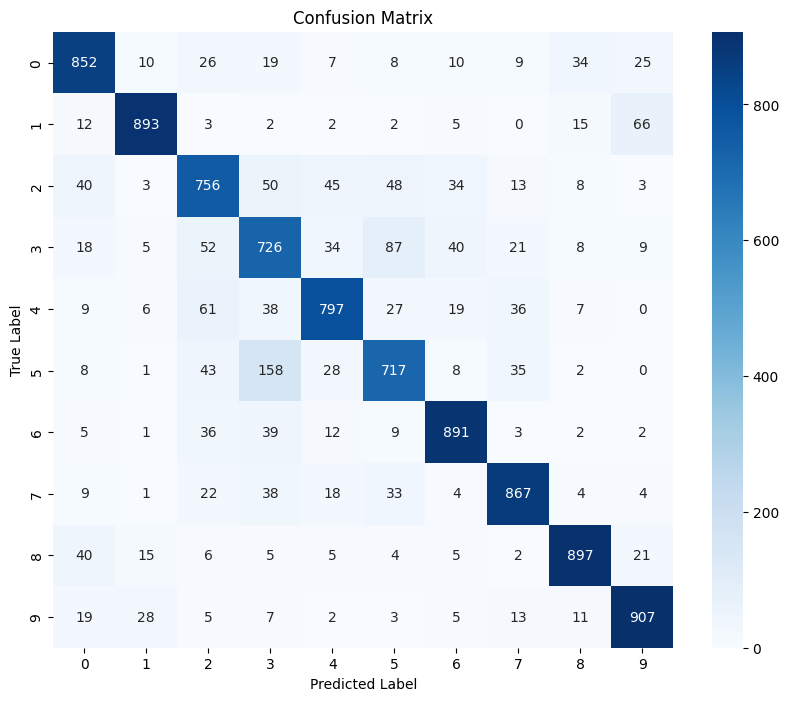

In [14]:
draw_matrix(all_predictions,all_labels)